In [ ]:
import sqlite3
import pickle
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr
from scipy.stats import pearsonr
from hdbscan import HDBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### 1. Load data

In [2]:
# Define the database folder path and file names
db_folder = '../../data/processed_data/yelp_data/'
db_files = ['yelp_business_data.db', 'yelp_review_data.db']
db_paths = [db_folder + db_file for db_file in db_files]

In [4]:
# Connect to the databases and load data
def load_data_from_db():
    data = {}
    
    # Open connections and read tables
    conns = [sqlite3.connect(db_path) for db_path in db_paths]
    try:
        # Load tables from the databases
        data['business'] = pd.read_sql_query("SELECT * FROM business_details", conns[0])
        data['categories'] = pd.read_sql_query("SELECT * FROM business_categories", conns[0])
        data['review'] = pd.read_sql_query("SELECT * FROM review_data", conns[1])
    finally:
        # Close all database connections
        for conn in conns:
            conn.close()
    return data

In [5]:
# Load data into a dictionary
yelp_data = load_data_from_db()

# Check loaded data
for table, df in yelp_data.items():
    print(f"Loaded {len(df)} rows from {table} table.")

Loaded 78059 rows from business table.
Loaded 360656 rows from categories table.
Loaded 980418 rows from review table.


In [6]:
df_business = yelp_data['business'] # Business details
df_categories = yelp_data['categories'] # Business categories
df_review = yelp_data['review'] # Review data


In [7]:
df_review['label'] = df_review['stars'].apply(lambda x: 1 if x > 4 else 0)

### 2. Dataset overview

In [7]:
print(df_review.columns)

Index(['review_id', 'user_id', 'business_id', 'stars', 'date', 'text',
       'useful', 'funny', 'cool', 'label'],
      dtype='object')


In [8]:
print(df_business.columns)

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'hours'],
      dtype='object')


In [9]:
print(df_categories.columns)

Index(['business_id', 'category'], dtype='object')


In [10]:
display(df_review.head(5))

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,label
0,f1MJKwk8Nk2MNxns6-tvfg,BDwy_2vFLT2urUhvNrKDLQ,8yR12PNSMo6FBYx1u5KPlw,4.0,2020-01-21 16:10:04,"I know this is a burger spot, but I loooove th...",1,0,0,0
1,pixVBYRdOuSPoeCSzXYVEg,s8jr65E_xPSW84nh6CG94w,hyFzDuyOWNG2rg5GYJ2wiQ,4.0,2019-04-21 02:44:33,Make a reservation! It's a cute and small spac...,2,0,0,0
2,yCtvsHB7_TsQ90xt-cXh4Q,uBHAc_FrPUd_1eZZgUrYMw,QU0tsRJw8vabl_tYkN2vqw,5.0,2017-06-04 22:21:07,The revamped theaters look amazing. Love the r...,1,0,0,1
3,QIJ1WG42Cgbnr3GudPjNmg,DBpcvcKAYaf_JLH4gp_EZA,-1MhPXk1FglglUAmuPLIGg,3.0,2009-08-03 00:02:04,The philly cheese steak was very good and the ...,1,0,1,0
4,okYXLbzrcRrrcqkaboS6Jw,xxTbaKNocxzsYyUoyxnELA,yPSejq3_erxo9zdVYTBnZA,5.0,2018-05-08 01:59:31,Best Mexican place in Santa Barbara County. I'...,1,0,0,1


In [11]:
display(df_business.head(5))

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,hours
0,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
2,UJsufbvfyfONHeWdvAHKjA,Marshalls,21705 Village Lakes Sc Dr,Land O' Lakes,FL,34639,28.190459,-82.457380,3.5,6,1,"{'RestaurantsPriceRange2': '2', 'BikeParking':...","{'Monday': '9:30-21:30', 'Tuesday': '9:30-21:3..."
3,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
4,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","{'Monday': '10:0-18:0', 'Tuesday': '10:0-20:0'..."


In [12]:
display(df_categories.head(5))

,business_id,category
0,tUFrWirKiKi_TAnsVWINQQ,Department Stores
1,tUFrWirKiKi_TAnsVWINQQ,Shopping
2,tUFrWirKiKi_TAnsVWINQQ,Fashion
3,tUFrWirKiKi_TAnsVWINQQ,Home & Garden
4,tUFrWirKiKi_TAnsVWINQQ,Electronics


<Axes: >

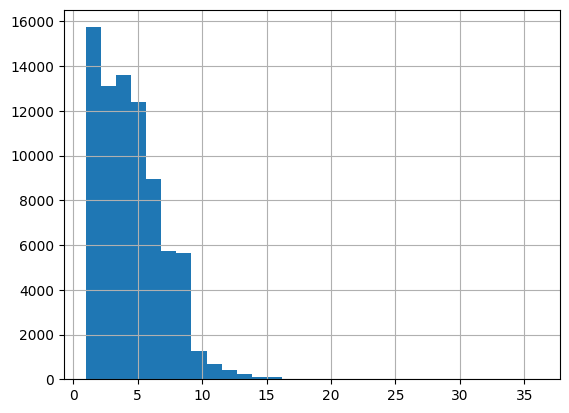

In [ ]:
# find rows in df_categories that have the same business_id
df_categories = df_categories.groupby('business_id')['category'].apply(list).reset_index(name='categories') 
# limit the number of categories to 5
df_categories['categories'] = df_categories['categories'].apply(lambda x: x[:5] if len(x) > 5 else x)
# fill the missing values with 'None'
df_categories['categories'] = df_categories['categories'].apply(lambda x: x + ['None']*(5-len(x)))

In [ ]:
# Clean and truncate
def clean_categories(cat_list):
    cleaned = [cat for cat in cat_list if cat != "None"][:5]  # Remove None, take first 5
    return cleaned + [0] * (5 - len(cleaned))  # Pad with 0

df_categories["categories"] = df_categories["categories"].apply(clean_categories)

In [ ]:
'''
from sklearn.preprocessing import LabelEncoder
# Build vocabulary and encode
all_categories = set()
df_categories["categories"].apply(lambda x: [all_categories.add(cat) for cat in x if cat != 0])
le = LabelEncoder()
le.fit(list(all_categories))

# Convert to indices
df_categories["encoded"] = df_categories["categories"].apply(lambda x: [le.transform([cat])[0] if cat != 0 else 0 for cat in x])

df_categories_encoded = df_categories[["business_id", "encoded"]]
# split the encoded categories into 5 columns
df_categories_encoded = pd.concat([df_categories_encoded["business_id"], df_categories_encoded["encoded"].apply(lambda x: pd.Series(x))], axis=1)
df_categories_encoded.columns = ["business_id", "category1", "category2", "category3", "category4", "category5"]

# 8 min run time
'''

                  business_id                     encoded
0      --30_8IhuyMHbSOcNWd6DQ    [1131, 7, 427, 621, 681]
1      --7PUidqRWpRSpXebiyxTg   [154, 951, 753, 753, 753]
2      --8IbOsAAxjKRoYsBFL-PA   [438, 951, 607, 753, 753]
3      --FcbSxK1AoEtEAxOgBaCw    [199, 81, 753, 753, 753]
4      --N9yp3ZWqQIm7DqKRvorg     [81, 78, 77, 1116, 766]
...                       ...                         ...
78027  zzXDi0Pdv0s84M-oQaIa_g    [528, 638, 735, 804, 62]
78028  zzbZtgPYZS8sTIWQH6DwEw    [438, 31, 752, 951, 110]
78029  zzjFdJwXuxBOGe9JeY_EMw   [205, 951, 753, 753, 753]
78030  zznJox6-nmXlGYNWgTDwQQ   [438, 951, 246, 342, 753]
78031  zztOG2cKm87I6Iw_tleZsQ  [1107, 1041, 12, 362, 753]

[78032 rows x 2 columns]


In [ ]:
# df_categories_encoded.to_csv("encoded_categories.csv", index=False)

In [12]:
df_categories_encoded = pd.read_csv("encoded_categories.csv")

df_business = df_business.merge(df_categories_encoded, on="business_id", how="left")


## 2. Correlation Analysis

In [14]:
df_business = df_business.rename(columns={'stars': 'business_stars'})
df_review = df_review.rename(columns={'stars': 'review_stars'})
df_review_merged = df_review.merge(df_business, on='business_id', how='left')

In [16]:
continuous_columns = ['review_stars', 'useful', 'funny', 'cool', 'latitude', 'longitude', 
                      'business_stars', 'review_count']

In [17]:
# Calculate point-biserial correlation for each feature
correlations = {}
for feature in continuous_columns:
    # Drop any rows with missing values in the feature or label to avoid errors
    valid_data = df_review_merged[[feature, 'label']].dropna()
    corr, p_value = pointbiserialr(valid_data[feature], valid_data['label'])
    correlations[feature] = {'correlation': corr, 'p_value': p_value}

# Display the results
print("Correlation Analysis Results:")
print("-----------------------------")
for feature, stats in correlations.items():
    print(f"{feature}:")
    print(f"  Correlation = {stats['correlation']:.3f}")
    print(f"  p-value = {stats['p_value']:.3f}")
    print()

Correlation Analysis Results:
-----------------------------
review_stars:
  Correlation = 0.749
  p-value = 0.000

useful:
  Correlation = -0.020
  p-value = 0.000

funny:
  Correlation = -0.028
  p-value = 0.000

cool:
  Correlation = 0.040
  p-value = 0.000

latitude:
  Correlation = -0.039
  p-value = 0.000

longitude:
  Correlation = -0.038
  p-value = 0.000

business_stars:
  Correlation = 0.320
  p-value = 0.000

review_count:
  Correlation = 0.025
  p-value = 0.000



## 3. PCA

In [24]:
features = ['review_stars', 'useful', 'funny', 'cool', 'latitude', 'longitude', 
                      'business_stars', 'review_count', 'category1', 'category2', 'category3', 'category4', 'category5']

In [25]:
X = df_review_merged[features]
# fill missing values with 0
X = X.fillna(0)
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Check explained variance ratio
print(pca.explained_variance_ratio_)

[0.1882831  0.11541436 0.08669678 0.07925921 0.07806369 0.07678428
 0.07613937 0.07479296 0.07395987 0.06554859 0.04329215 0.03122918
 0.01053646]


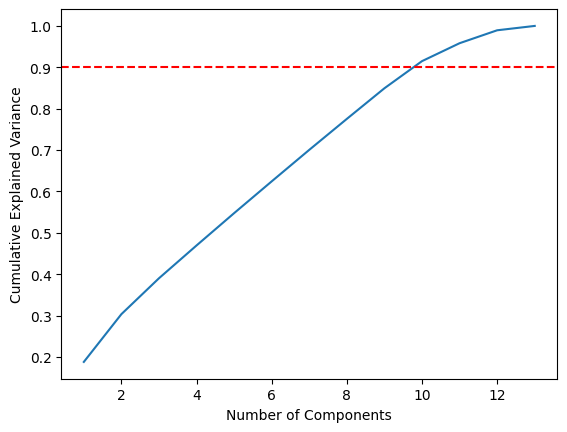

Number of components explaining 90% of variance: 10


In [26]:
import matplotlib.pyplot as plt
cumulative_variance = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()
# print the number of components that explain 90% of the variance
n_components = (cumulative_variance < 0.9).sum() + 1
print(f"Number of components explaining 90% of variance: {n_components}")

In [27]:
# Choose the number of components
n_components = n_components  # Change this value
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X_scaled)

# Convert to DataFrame for easier handling
new_feature_names = [f'PC{i+1}' for i in range(n_components)]
X_pca_df = pd.DataFrame(X_pca_reduced, columns=new_feature_names)


In [29]:
loadings = pd.DataFrame(pca.components_.T, columns=new_feature_names, index=features)
print("Feature Loadings for Each Principal Component:")
print(loadings)

Feature Loadings for Each Principal Component:
                     PC1       PC2       PC3       PC4       PC5       PC6  \
review_stars    0.016391  0.637303 -0.239203  0.086776  0.081681 -0.031087   
useful          0.590545 -0.045756  0.006725 -0.005197  0.008114  0.006045   
funny           0.537834 -0.046140  0.042402 -0.025728 -0.003387  0.017280   
cool            0.599924  0.047832 -0.005703  0.005570  0.008373  0.001377   
latitude       -0.005954 -0.158522 -0.327743  0.547183  0.449817  0.095688   
longitude      -0.028441 -0.019646  0.224061 -0.491151  0.162547  0.292359   
business_stars  0.025226  0.669670 -0.149749  0.037259  0.039045 -0.001971   
review_count   -0.015617  0.328837  0.538276 -0.060612 -0.128338  0.024255   
category1      -0.002903  0.010198 -0.229945  0.030045 -0.384848  0.701899   
category2      -0.007203  0.036374  0.071690 -0.307402  0.694680 -0.043227   
category3      -0.000590  0.024180 -0.169408 -0.210979  0.283749  0.536197   
category4       0

In [30]:
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Total variance explained by {n_components} components: {explained_variance:.3f}")

Total variance explained by 10 components: 0.915


In [31]:
df_review_reduced = pd.concat([df_review_merged[['review_id', 'user_id', 'business_id', 'label']], X_pca_df], axis=1)
df_review_reduced

,review_id,user_id,business_id,label,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,f1MJKwk8Nk2MNxns6-tvfg,BDwy_2vFLT2urUhvNrKDLQ,8yR12PNSMo6FBYx1u5KPlw,0,-0.431539,0.763346,0.817149,0.719140,-0.877770,0.034381,-1.346752,0.343704,-0.602178,1.663416
1,pixVBYRdOuSPoeCSzXYVEg,s8jr65E_xPSW84nh6CG94w,hyFzDuyOWNG2rg5GYJ2wiQ,0,-0.241327,0.470332,-1.097537,-0.900867,0.577983,-0.700983,-2.188862,0.095024,-0.138509,0.672593
2,yCtvsHB7_TsQ90xt-cXh4Q,uBHAc_FrPUd_1eZZgUrYMw,QU0tsRJw8vabl_tYkN2vqw,1,-0.432480,-0.539306,-0.392341,-0.147941,0.470105,-0.611131,0.588128,1.673249,1.134496,-0.016001
3,QIJ1WG42Cgbnr3GudPjNmg,DBpcvcKAYaf_JLH4gp_EZA,-1MhPXk1FglglUAmuPLIGg,0,-0.139098,-0.143659,-0.361847,0.709454,-1.148034,0.408093,1.933017,0.281664,-1.872217,-0.578786
4,okYXLbzrcRrrcqkaboS6Jw,xxTbaKNocxzsYyUoyxnELA,yPSejq3_erxo9zdVYTBnZA,1,-0.386156,3.109361,1.629911,-0.003479,-0.471975,-0.337822,1.290314,-2.117609,-1.030743,3.830537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980413,mTh3f9I5yBt7kJcu-JmNvQ,x-aHM9y-vc5l2-XK4G6z1A,BEMSDLPP630Fpdw_QpqLVA,0,-0.553349,0.448982,0.986325,-0.474966,-1.073240,-0.992646,-0.446646,-0.447169,1.843111,-1.020768
980414,rjQjXnKNLT7QtqQKtsdsJg,XUpSR1CTDuAz0ZqYM1Y4jA,fOhnSqmO4XY5vSI8whVKSA,0,-0.436873,-0.053886,0.562270,0.020925,-0.313159,-0.498450,0.845112,2.231207,0.168371,1.232003
980415,Tlk60w0gqPWAei1vNz2SQg,bWmmKhZeu3aI6iFBjkP-Ag,RJehYyeYwaU3SsscuZP2cA,1,-0.096450,1.105444,-1.071721,1.758680,0.037884,-0.715158,-0.222526,-1.398146,-0.237497,-0.183010
980416,kuUsTxYTYdrO9Imh3brzHQ,Kc7IwXLrJVqAVMkX6pxWbA,i7k-gVxU5Jjca3MCNSL4Sw,0,0.947242,-1.711070,1.445805,-0.784682,-0.565308,-0.267285,1.236924,-0.446019,2.219202,-1.135708


In [32]:
# export the reduced data to csv
df_review_reduced.to_csv("reduced_review_data.csv", index=False)

In [2]:
df_review_reduced = pd.read_csv("reduced_review_data.csv")
X_pca_reduced = df_review_reduced.drop(columns=['review_id', 'user_id', 'business_id', 'label']).values

## 4. Clustering - HDBSCAN

In [6]:
# Optimize memory usage
X_pca_reduced = X_pca_reduced.astype(np.float32)

# New parameter settings
hdbscan = HDBSCAN(
    min_cluster_size=5,      # Minimum cluster size
    min_samples=5,           # Lowered to reduce noise
    cluster_selection_epsilon=0.3,  # Merge clusters closer than 0.5
    metric='euclidean'
)

cluster_labels = hdbscan.fit_predict(X_pca_reduced)
df_review_reduced['cluster'] = cluster_labels


In [7]:
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

Number of clusters: 35891
Number of noise points: 301046


In [8]:
df_review_reduced.to_csv("clustered_review_data_5.csv", index=False)

In [3]:
df_review_reduced = pd.read_csv("clustered_review_data_4.csv")
cluster_labels = df_review_reduced['cluster'].values

Evaluate the cluster

In [9]:
from sklearn.metrics import silhouette_score
subsample_idx = np.random.choice(X_pca_reduced.shape[0], size=10000, replace=False)
X_sub = X_pca_reduced[subsample_idx]
labels_sub = cluster_labels[subsample_idx]
score = silhouette_score(X_sub, labels_sub)
print(f"Silhouette Score (subsample): {score:.3f}")

Silhouette Score (subsample): -0.147


In [10]:
from sklearn.metrics import davies_bouldin_score
db_score = davies_bouldin_score(X_sub, labels_sub)
print(f"Davies-Bouldin Score (subsample): {db_score:.3f}")

Davies-Bouldin Score (subsample): 1.079
